# Diffraction patterns of various apertures

This notebook defines functions that let you set up E-field patterns on a primary
optic, then takes the Fourier transform to give the Frauenhofer diffraction pattern.

A variety of examples are shown.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import scipy.interpolate as spi
%matplotlib inline  
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [10, 6]
c = 3e8

# Screens  
Our apertures will be defined on "screens", 
which are defined as dictionaries.  A screen is a square
object that has the following properties:

    screen['N'] : number of elements across the square
    screen['D'] : physical size of the x or y dimension, in meters.
    screen['X'] : 2D array of X coordinate values (0 at center)
    screen['Y'] : 2D array of Y coordinate values (0 at center)
    screen['E'] : N x N array of (complex) E-fields
    screen['FFT_E'] : FFT of screen['E'] (unshifted)
    screen['I'] : Intensity, ie np.abs(FFT_E)**2 
    screen['kx'] : 2D array of kx values
    screen['ky'] : 2D array of ky values



In [2]:
def Initialize(screen):
    # must run this first
    # It modifies the screen dictionary in place.
    # Before calling this, you have to first define 
    #   screen['N'] == number of pixels across the screen, and
    #   screen['D'] == the physical length across the screen.
    # These two values are used to populate various new elements in the dictionary 
    # associated with the screen pixels and k-values of the FFT.
    #
    n = screen['N']
    xvec = np.linspace(0,screen['D'],n)
    screen['X'] = np.tile(xvec,(len(xvec),1))
    screen['Y'] = screen['X'].T #np.flipud(screen['X'].T)
    screen['E'] = np.ones((n,n))
    dk = 2*np.pi/screen['D']
    screen['dk']=dk
    kvec = dk*np.fft.fftfreq(n)*n
    screen['kvec'] = kvec
    screen['kx']= np.fft.fftshift(np.tile(kvec,(kvec.size,1)))
    screen['ky']= screen['kx'].T #np.flipud(screen['kx'].T)
    screen['kap']= np.sqrt(screen['kx']**2 + screen['ky']**2)  # k vector in aperture plane

def Project_I_on_thetagrid(theta_vec,screen,lam):
    # Run after you've calculated the intensity as a function of kx, ky.
    # thetavec = 1D array of positions to be used for thetax, and for thetay
    #
    # Make 2D arrays of thetax, thetay coordinate for our map
    # We use the "_grid" suffix to indicate things that are 2D arrays associated
    # with the (new) thetax_grid, thetay_grid created next.
    N_thetagrid = len(theta_vec)
    thetax_grid, thetay_grid = np.meshgrid(theta_vec,theta_vec)
    thetay_grid = np.flipud(thetay_grid)
    #
    kphot = 2*np.pi/lam    # photon k vector.
    #
    # Find kx and ky at each (thetax,thetay) grid spot
    #
    kx_grid = kphot*thetax_grid/(np.pi/2)
    ky_grid = kphot*thetay_grid/(np.pi/2)
    #
    # Now look at the original kx,ky map of our FT screen.
    #
    I_grid = np.zeros((N_thetagrid, N_thetagrid))
    
    dk = screen['kx'][0,1]-screen['kx'][0,0]
    for xx in range(N_thetagrid):
        for yy in range(N_thetagrid):
            kx = kx_grid[yy,xx]
            ky = ky_grid[yy,xx]
            #
            nx = kx/dk + screen['N']/2  # what element is this in the screen's kx,ky
            ny = ky/dk + screen['N']/2
            #
            # find the four values of kx,ky that surround
            nx1 = int(np.floor(nx))
            nx2 = int(np.ceil(nx))
            ny1 = int(np.floor(ny))
            ny2 = int(np.ceil(ny))
            # Go through four points surrounding our grid point's position and take weighted average.
            numsum = 0
            denomsum = 0
            for pt in [(nx1,ny1), (nx1,ny2), (nx2,ny1), (nx2,ny2)]:
                rr2 = (kx - screen['kx'][pt[0],pt[1]])**2 + (ky - screen['ky'][pt[0],pt[1]])**2
                w = 1/rr2
                numsum += w*screen['I'][pt[0],pt[1]]
                denomsum += w
                #numsum += screen['I'][pt[0],pt[1]]
                #denomsum += 1
            I_grid[xx,yy] = numsum/denomsum
            #I_grid[xx,yy] = screen['I'][nx2,ny1]
        
    return I_grid
    
def InCircle(screen,center,radius):
    # Must have called makeXY first.
    # center must be a tuple, (xcenter,ycenter) in meters
    # radius in meters
    x0 = center[0]
    y0 = center[1]
    R = np.sqrt((screen['X']-x0)**2 + (screen['Y']-y0)**2)
    cut_ap = np.where(R<radius,1,0)
    screen['E']=screen['E']*cut_ap

def CircleAtten(screen,center,radius,factor):
    x0 = center[0]
    y0 = center[1]
    R = np.sqrt((screen['X']-x0)**2 + (screen['Y']-y0)**2)
    atten_ap = np.where(R<radius,factor,1)
    screen['E']=screen['E']*atten_ap
    
def CDpanelgap_mask(screen):
    # SO secondary (from image) has 9 panels in "x" across about a 6m aperture, 
    # so they are 0.667 meters in size.
    # We build a 5m mirror with similar panel sizes here, not trying to be exact.
    #
    slit_centers1 = np.arange(0.0,2.5,0.667)
    slit_centers2 = -slit_centers1[1:]
    slit_centers = np.concatenate((slit_centers2[::-1],slit_centers1))
    print(slit_centers)
    slit_width = 0.0007 #mm
    #
    pix_size = screen['D']/screen['N']
    xvec = np.linspace(-screen['D']/2,screen['D']/2,screen['N'])  # centered at zero
    onerow = np.ones(len(xvec))
    
    if pix_size >= slit_width:
        print("Pixel size >= slit width:  Removing one column/row for each slit.")
        for ii in range(len(slit_centers)):
            slitlocator = np.abs(xvec - slit_centers[ii])
            slitloc = np.argmin(slitlocator)
            onerow[slitloc] = 0
    else:
        print("Pixel size <= slit width:  Removing multiple columns/rows for each slit.")
        for ii in range(len(slit_centers)):
            slitlocator = np.abs(xvec - slit_centers[ii])
            slitloc = np.where(slitlocator < (pix_size/1.9))
            onerow[slitloc] = 0
    
    plt.plot(onerow)
    gapmask_x = np.tile(onerow,(len(onerow),1)) 
    gapmask_y = gapmask_x.T
    gapmask = gapmask_x*gapmask_y
    #screen['E']=screen['E']*gapmask
    return gapmask
    

def MultByGaussian(screen, center, sigma):
    # center must be a tuple, (xcenter,ycenter)
    x0 = center[0]
    y0 = center[1]
    R = np.sqrt((screen['X']-x0)**2 + (screen['Y']-y0)**2)
    screen['E']=screen['E']*np.exp(-(R**2)/(2*sigma**2))

def RMS_phase(screen,phase_rms):
    n = screen['N']
    phase = phase_rms*np.random.standard_normal(size=(n,n))
    screen['E']= screen['E']*np.exp(1j*phase)
    
def ScreenFFT(screen):
    screen['FFT_E'] = np.fft.fftshift(np.fft.fft2(screen['E']))
    screen['I'] = np.abs(screen['FFT_E'])**2
    
def PlotScreenAndFFT(screen):
    d2 = screen['D']/2
    #
    # Plot screen E-field
    fig,axs = plt.subplots(1,2)
    aa = axs[0].imshow(np.real(screen['E']),origin='lower',extent=[-d2,d2,-d2,d2])
    fig.colorbar(aa,ax=axs[0])
    #
    theta_max = np.max(screen['theta_vec_arcmin'])
    print(theta_max)
    bb = axs[1].imshow(np.abs(screen['FFT_E']),origin='lower')#,extent=[-theta_max,theta_max,-theta_max,theta_max])
    theta = np.linspace(0,2*np.pi,100)
    
    #plt.plot(kmax*np.cos(theta),kmax*np.sin(theta),'r')
    #axs[1].set_xlim(-10,10)
    #axs[1].set_ylim(-10,10)
    #fig.colorbar(bb,ax=axs[1])

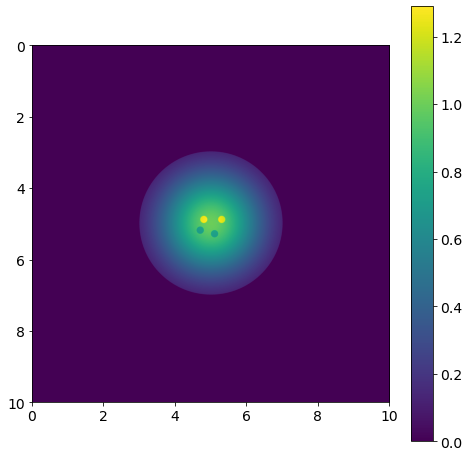

In [3]:


screen={}
screen['N']=5000
screen['D']=10.0
Initialize(screen)

center = (screen['D']/2,screen['D']/2)

#gapmask = CDpanelgap_mask(screen)
#screen['E']=screen['E']*gapmask

plt.rcParams['figure.figsize'] = [8, 8]

#RMS_phase(screen,1.0)
MultByGaussian(screen,center,1.0)
InCircle(screen,center,2.0)
c2 = (center[0]-0.2, center[1]-0.1)
CircleAtten(screen,c2,0.1,1.3)
c2 = (center[0]+0.1, center[1]+0.3)
CircleAtten(screen,c2,0.1,1/1.3)
c2 = (center[0]+0.3, center[1]-0.1)
CircleAtten(screen,c2,0.1,1.3)
c2 = (center[0]-0.3, center[1]+0.2)
CircleAtten(screen,c2,0.1,1/1.3)
plt.imshow(screen['E'],extent=(0,screen['D'],screen['D'],0))
plt.colorbar()

In [4]:
ScreenFFT(screen)

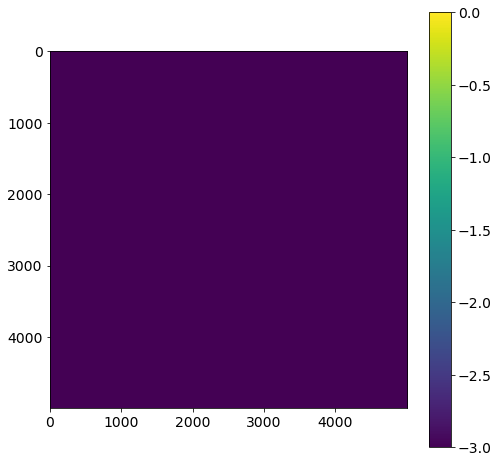

In [5]:
#low = 480
#high=520
#plt.imshow(screen['I'][low:high,low:high]) #[low:high][low:high])
Imax = np.max(screen['I'])
#plt.imshow(screen['I']/Imax)
xyz = np.log10(np.abs(screen['I']/Imax))
plt.imshow(xyz,vmin=-3)
plt.colorbar()

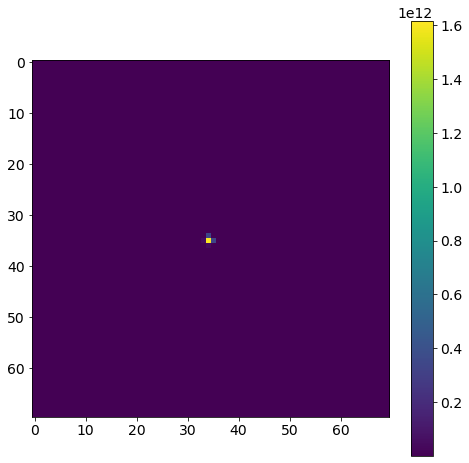

In [7]:
lam = 0.002 #mm wavelength
kphot = 2*np.pi/lam
# 
thetamax = 2*np.pi/180. # 2 degrees
theta_vec = np.arange(-thetamax,thetamax,0.001) 
II = Project_I_on_thetagrid(theta_vec,screen,lam) 
plt.imshow(II, interpolation = None) 
plt.colorbar()


0.6283185307179338
(-6.78e+01, -6.78e+01), (-6.79e+01, -6.79e+01) : (2392, 2392), 1.59e-03, 1.59e-03, 3.18e-03)
(-6.78e+01, -6.78e+01), (-6.72e+01, -6.79e+01) : (2392, 2393), 3.46e-01, 1.59e-03, 3.48e-01)
(-6.78e+01, -6.78e+01), (-6.79e+01, -6.72e+01) : (2393, 2392), 1.59e-03, 3.46e-01, 3.48e-01)
(-6.78e+01, -6.78e+01), (-6.72e+01, -6.72e+01) : (2393, 2393), 3.46e-01, 3.46e-01, 6.92e-01)


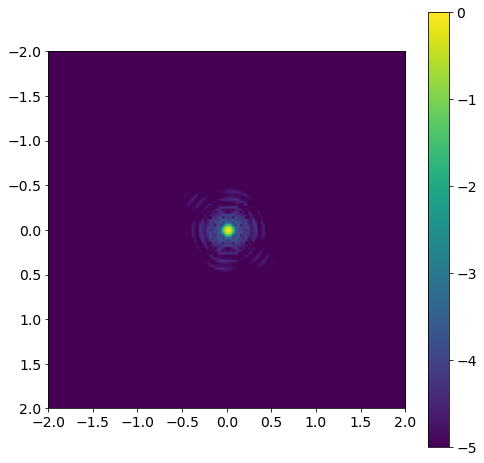

In [8]:
lam = 0.002 #mm wavelength
kphot = 2*np.pi/lam
# 
thetamaxdeg = 2.0
thetamax = thetamaxdeg*np.pi/180. # 0.2 degrees
dtheta = thetamax/70
theta_vec = np.arange(-thetamax,thetamax,dtheta) 

N_thetagrid = len(theta_vec)
thetax_grid, thetay_grid = np.meshgrid(theta_vec,theta_vec)
#thetay_grid = np.flipud(thetay_grid)
#
kphot = 2*np.pi/lam    # photon k vector.
#
# Find kx and ky at each (thetax,thetay) grid spot
#
kx_grid = kphot*thetax_grid/(np.pi/2)
ky_grid = kphot*thetay_grid/(np.pi/2)
#
# Now look at the original kx,ky map of our FT screen.
#
I_grid = np.zeros((N_thetagrid, N_thetagrid))

dk = screen['kx'][0,1]-screen['kx'][0,0]
print(dk)
for xx in range(N_thetagrid):
    for yy in range(N_thetagrid):
        kx = kx_grid[yy,xx]
        ky = ky_grid[yy,xx]
        #
        nx = kx/dk + screen['N']/2  # what element is this in the screen's kx,ky
        ny = ky/dk + screen['N']/2

        #
        # find the four values of kx,ky that surround
        nx1 = int(np.floor(nx))
        nx2 = int(np.ceil(nx))
        ny1 = int(np.floor(ny))
        ny2 = int(np.ceil(ny))
        # Go through four points surrounding our grid point's position and take weighted average.
        numsum = 0
        denomsum = 0
        for pt in [(ny1,nx1), (ny1,nx2), (ny2,nx1), (ny2,nx2)]:
            xx2 = (kx - screen['kx'][pt[0],pt[1]])**2
            yy2 = (ky - screen['ky'][pt[0],pt[1]])**2
            rr2 = xx2 + yy2
            w = 1/rr2
            numsum += w*screen['I'][pt[0],pt[1]]
            denomsum += w
            if (xx == 2) and (yy == 2):
                print('({0:3.2e}, {1:3.2e}), ({2:3.2e}, {3:3.2e}) : ({4:2d}, {5:2d}), {6:3.2e}, {7:3.2e}, {8:3.2e})'.format(kx,ky,screen['kx'][pt[0],pt[1]],screen['ky'][pt[0],pt[1]],pt[0],pt[1],xx2,yy2,rr2))
            #numsum += screen['I'][pt[0],pt[1]]
            #denomsum += 1
        I_grid[xx,yy] = numsum/denomsum

plt.imshow(np.log10(I_grid/np.max(I_grid)), vmin=-5,interpolation = None,extent=[-thetamaxdeg,thetamaxdeg,thetamaxdeg,-thetamaxdeg]) 
plt.colorbar()
#print(theta_vec)

In [9]:
I_0 = I_grid

In [10]:
I_1 = I_grid


In [11]:
Idiff = I_1 - I_0
print(Idiff)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


<ipython-input-12-6858200ab6ce>:9: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(Idiff)),vmin=0,vmax=10,interpolation = None,extent=[-thetamaxdeg,thetamaxdeg,thetamaxdeg,-thetamaxdeg])


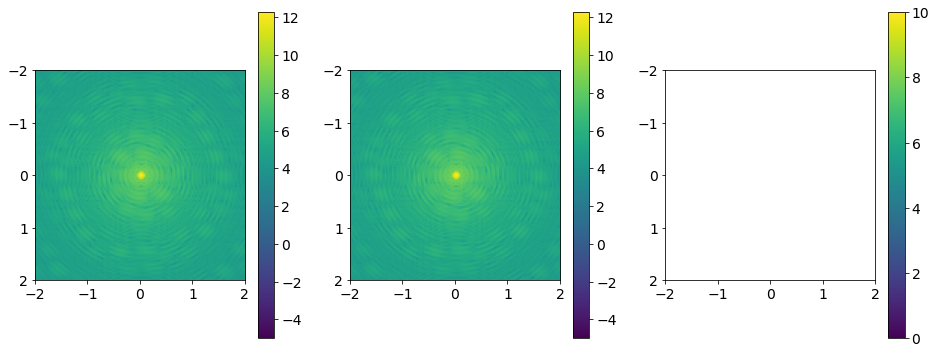

In [12]:
plt.rcParams['figure.figsize'] = [16, 6]
plt.subplot(1,3,1)
plt.imshow(np.log10(np.abs(I_0)),vmin=-5,interpolation = None,extent=[-thetamaxdeg,thetamaxdeg,thetamaxdeg,-thetamaxdeg])
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(np.log10(np.abs(I_1)),vmin=-5,interpolation = None,extent=[-thetamaxdeg,thetamaxdeg,thetamaxdeg,-thetamaxdeg])
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.log10(np.abs(Idiff)),vmin=0,vmax=10,interpolation = None,extent=[-thetamaxdeg,thetamaxdeg,thetamaxdeg,-thetamaxdeg])
plt.colorbar()

<ipython-input-13-90a1d09b9b7e>:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(Idiff)),vmin=7,interpolation = None,extent=[-thetamaxdeg,thetamaxdeg,thetamaxdeg,-thetamaxdeg])


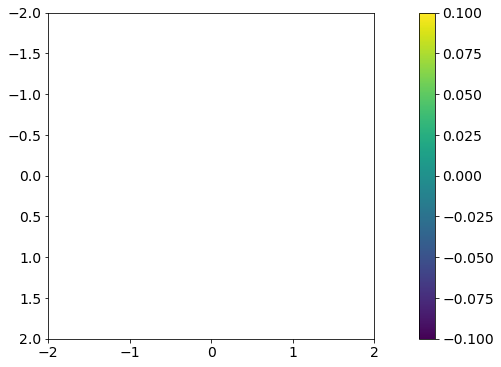

In [13]:
plt.imshow(np.log10(np.abs(Idiff)),vmin=7,interpolation = None,extent=[-thetamaxdeg,thetamaxdeg,thetamaxdeg,-thetamaxdeg])
plt.colorbar()

<ipython-input-14-ef0a2a07123f>:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(psd0-psd1)))


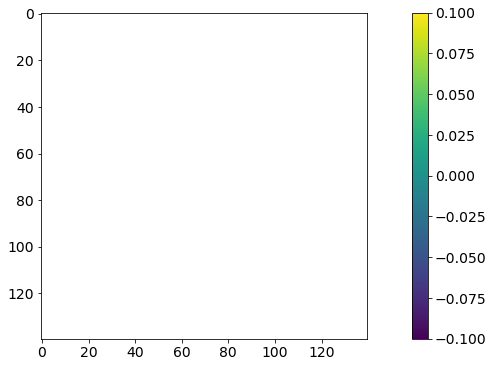

In [14]:
psd0 = np.fft.fftshift(np.abs(np.fft.fft2(I_0)))
psd1 = np.fft.fftshift(np.abs(np.fft.fft2(I_1)))
plt.imshow(np.log10(np.abs(psd0-psd1)))
plt.colorbar()


KeyError: 'theta_vec_arcmin'

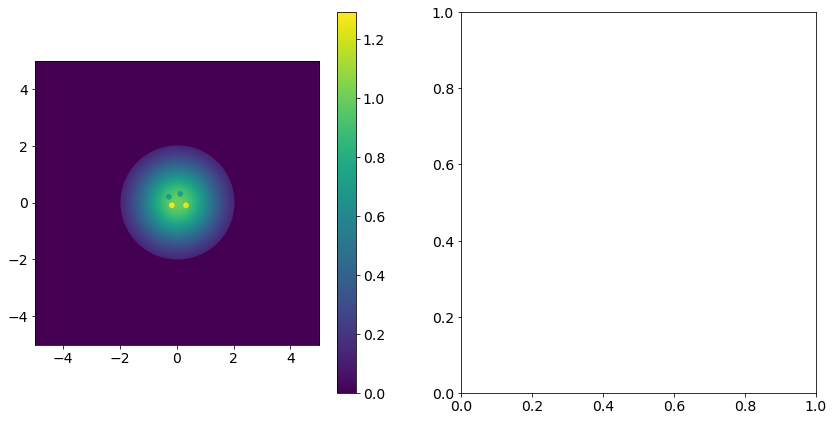

In [15]:
plt.rcParams['figure.figsize'] = [14, 7]
PlotScreenAndFFT(screen)

In [16]:
##### Now set up the aperture
N = 1000   # resolution elements across the aperture
x0 = N/2. # center of opening
y0 = x0
screen1 = np.zeros((N,N))
screen2 = np.zeros((N,N))
# Set up details of system
D_ap = 5.0  
# Size of the (square) aperture screen 
# (larger than the TMA primary diameter in meters)

xmax = D_ap/2.  # screen goes from -xmax to +xmax (and same in y)
lam = 0.01   # meters, wavelength of light
k = 2*np.pi/lam  # k-vector of incident light
dk = 1/D_ap    # transverse k_vector bin width


# Choose an aperture E-field distribution
#

#screen = inboxA(screen,(x0,y0),N/10)

#screen = incircleA(screen,(x0,y0),N/5.)

sigma_elements = N/3.

time1a = datetime.now()
print('time1a: ',time1a)


screen1= gaussian(screen1, (x0,y0),sigma_elements)
time1aa = datetime.now()
print('time1aa: ',time1aa)

screen2= incircleA(screen2,(x0,y0),N/4)
time1b = datetime.now()
print('time1b: ',time1b)

rms_phi = 3.0
phase = rms_phi*np.random.standard_normal(size=(N,N))

screen2= screen2*np.exp(1j*phase)
screen1 = screen1*screen2

#screen = slitgrid()
#screen = xslit(screen,N/2,10)
time1c = datetime.now()
print('time1c: ',time1c)
n_elements = screen.shape[0]
kvec = dk*np.fft.fftfreq(n_elements)*n_elements # renormalize fftfreq grid 
#
# Generate 2D array of kx and ky values for each point in the k_plane
kx_array = np.fft.fftshift(np.tile(kvec,(kvec.size,1)))
ky_array = kx_array.transpose()
# k_transverse = sqrt(k_x^2 + k_y^2) can't be larger than k.
# We will do the FFT, then eventually discard elements where k_transverse is higher than this
kt_array = np.sqrt(kx_array**2 + ky_array**2)


# Fourier transform gives kx,ky vector amplitudes, corresponding to thetas above.

time2 = datetime.now()
print('time2: ',time2)
E_beam = np.fft.fftshift(np.fft.fft2(screen))
time3 = datetime.now()
print('time3: ',time3)
#E_beam = np.where(kt_array < k, E_beam, 0)
I_beam = np.real(E_beam * np.conj(E_beam))

elapsed_time = endtime-starttime

print("FFT2 Time =", elapsed_time.microseconds)



#


# plotting
#
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [10, 6]
fig,axs = plt.subplots(1,2,constrained_layout=True)
axs[0].imshow(np.real(screen),origin='lower',interpolation='none', extent = [-xmax,xmax,-xmax,xmax])
axs[0].set_title('Aperture Field')
#axs[0].colorbar()
#
kmax = np.max(kvec)
im1 = axs[1].imshow((I_beam),origin='lower',interpolation='none',extent=[-kmax,kmax,-kmax,kmax])
axs[1].set_title('k-plane')
fig.colorbar(im1,ax=axs[1])
zz = 100
axs[1].set_xlim([-zz,zz])
axs[1].set_ylim([-zz,zz])
theta = np.linspace(0,2*np.pi,1000)
axs[1].plot(k*np.cos(theta),k*np.sin(theta),'r')

time1a:  2022-09-12 21:00:54.305754


NameError: name 'gaussian' is not defined

In [ ]:
plt.imshow(phase)
plt.colorbar()
np.std(phase)

In [ ]:
elapsed_time.microseconds

In [ ]:
np.std?

In [ ]:
np.degrees(2e-3/.1)*60
